# SP500 Stock Analysis

#### Using the SP500.csv provided within the file, select two stocks from the list.

# Imports

# StockSelection: 

Loads a CSV file containing data on S&P 500 companies, allows the user to select two stocks from the list, and returns their symbols and names.

In [45]:
import pandas as pd

class StockSelection:
    def __init__(self, csv_path="CSV/SP500.csv"):
        self.csv_path = csv_path
        self.stock_data = None
        self.load_stock_data()

    # Load stock data from a CSV file containing S&P 500 companies
    def load_stock_data(self):
        self.stock_data = pd.read_csv(self.csv_path)

    # Display the stocks with their symbols and names
    def display_stocks(self):
        print(self.stock_data[["Symbol", "Name"]])

    # Get stock information for a given stock symbol
    def get_stock(self, stock_symbol):
        stock = self.stock_data[self.stock_data["Symbol"] == stock_symbol]
        if not stock.empty:
            return stock[["Symbol", "Name"]].iloc[0]
        else:
            return None

    # Allow the user to select two stocks from the list
    def select_stocks(self):
        print("Please select two stocks from the list:")
        self.display_stocks()

        stocks = []
        while len(stocks) < 2:
            stock_symbol = input("Enter stock symbol: ").strip().upper()
            stock = self.get_stock(stock_symbol)
            if stock is not None:
                stocks.append(stock)
                print(f"Selected: {stock['Symbol']} - {stock['Name']}")
            else:
                print("Invalid stock symbol. Please try again.")

        return stocks

# DateSelection: 
Allows the user to input start and end dates in the YYYY-MM-DD format and returns them as datetime objects.

In [46]:
from datetime import datetime

class DateSelection:
    def __init__(self):
        self.start_date = None
        self.end_date = None

    # Validate the user input for date in the YYYY-MM-DD format
    def _input_validation(self, date_str):
        try:
            date = datetime.strptime(date_str, '%Y-%m-%d')
            return True
        except ValueError:
            return False

    # Get user input for a date and validate it
    def input_date(self, prompt):
        while True:
            date_str = input(prompt)
            if self._input_validation(date_str):
                date = datetime.strptime(date_str, '%Y-%m-%d').date()
                return date
            else:
                print("Invalid date format. Please use the YYYY-MM-DD format.")

    # Allow the user to select start and end dates for the analysis
    def select_dates(self):
        while self.start_date is None:
            self.start_date = self.input_date("Enter the start date (YYYY-MM-DD): ")

        while self.end_date is None:
            self.end_date = self.input_date("Enter the end date (YYYY-MM-DD): ")

        if self.start_date > self.end_date:
            print("Error: Start date cannot be later than the end date. Please try again.")
            self.start_date = None
            self.end_date = None
            self.select_dates()

        return self.start_date, self.end_date

# FetchData: 
Fetches historical stock data from Yahoo Finance API for a given list of stock symbols and date range, calculates various technical indicators (e.g., log returns, standard deviation, volatility, average daily volume), and returns the data as a dictionary of Pandas DataFrames.

In [47]:
import pandas as pd
import yfinance as yf
import numpy as np

class FetchData:
    def __init__(self, symbols, start_date, end_date):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.stock_data = {}

    # Fetch the stock data from Yahoo Finance
    def fetch_stock_data(self):
        for symbol in self.symbols:
            data = yf.download(symbol, start=self.start_date, end=self.end_date)
            self.stock_data[symbol] = data
        self.calculate_indicators()

    # Return the fetched stock data
    def get_stock_data(self):
        return self.stock_data

    # Calculate indicators for the fetched stock data
    def calculate_indicators(self):
        stock_prices = []

        # Reset the index for each stock data and append it to the stock prices list
        for symbol, data in self.stock_data.items():
            data = data.reset_index()
            data['Symbol'] = symbol
            stock_prices.append(data[['Symbol', 'Date', 'Adj Close', 'Volume']])

        # Concatenate all the stock data into a single DataFrame and rename the columns
        stock_prices_df = pd.concat(stock_prices)
        stock_prices_df = stock_prices_df.rename(columns={"Adj Close": "Price"})
        stock_list = stock_prices_df['Symbol'].unique().tolist()

        # Define constants for the moving average window and the number of trading days in a year
        MAwindow = 10
        StockDaysInYear = 250

        # Create an empty DataFrame to store the end of day data for the stocks
        stocks_eod_data = pd.DataFrame(columns=['Symbol', 'Date', 'Price', 'Volume', 'Log Return', 'Std Dev', 'Volatility', 'ADV', 'MDV'])
        
        # Calculate the indicators for each stock and append the data to the stocks_eod_data DataFrame
        for stock in stock_list:
            temp_df = stock_prices_df[stock_prices_df['Symbol'] == stock].copy()
            temp_df["Log Return"] = np.log(temp_df["Price"] / temp_df["Price"].shift(-1))
            temp_df["Std Dev"] = temp_df["Log Return"].rolling(MAwindow).std().shift(-MAwindow + 1)
            temp_df["Volatility"] = temp_df["Std Dev"] * StockDaysInYear**0.5
            temp_df["ADV"] = temp_df["Volume"].rolling(MAwindow).mean().shift(-MAwindow + 1).round(2)
            temp_df["MDV"] = temp_df["Volume"].rolling(MAwindow).median().shift(-MAwindow + 1).round(2)
            stocks_eod_data = pd.concat([temp_df, stocks_eod_data], join="inner")

        # Sort the stocks_eod_data DataFrame by symbol and date and fill any missing values with a placeholder
        stocks_eod_data = stocks_eod_data.sort_values(by=["Symbol", "Date"], ascending=[True, False])
        stocks_eod_data.fillna("#N/A", inplace=True)

        # Update the stock_data attribute with the calculated indicators
        self.stock_data = {symbol: stocks_eod_data[stocks_eod_data['Symbol'] == symbol] for symbol in stock_list}



# CheckPoint Main

In [48]:
# def main():
#     # Initialize the stock selection
#     stock_selection = StockSelection()

#     # Allow the user to select two stocks
#     selected_stocks = stock_selection.select_stocks()
#     stock_symbols = [stock["Symbol"] for stock in selected_stocks]

#     # Initialize the date selection
#     date_selection = DateSelection()

#     # Allow the user to select the start and end dates
#     start_date, end_date = date_selection.select_dates()

#     # Initialize the data fetcher
#     data_fetcher = FetchData(stock_symbols, start_date, end_date)

#     # Fetch the data
#     data_fetcher.fetch_stock_data()

#     # Get the fetched data
#     stock_data = data_fetcher.get_stock_data()

#     return stock_data


# if __name__ == "__main__":
#     main()



# GPTStock:
Uses OpenAI's GPT-3 API to generate natural language responses to user input in the context of stock analysis.

In [49]:
import openai
import os
from dotenv import load_dotenv

# Load environment variables from .env file
env_file = "env_vars.env"
if not load_dotenv(env_file):
    raise ValueError(f"Failed to load the environment variables from {env_file}")

# Get OpenAI API key from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is None:
    raise ValueError("OPENAI_API_KEY is not set in the environment variables.")
else:
    # Set OpenAI API key
    openai.api_key = openai_api_key

class GPT_Stock:
    def __init__(self, stock_symbols):
        """Initialize the object with the stock symbols"""
        self.stock_symbols = stock_symbols
        # Begin the conversation with the GPT-3 model with a system message
        self.messages = [{"role": "system", "content": f"You are a stock analysis. Provide a summary comparison of the following companies: {', '.join(stock_symbols)}. Make sure that you provide a paragraph for each company and a summary of your comparison, that is all you need."}]

    # Method to generate a comparison analysis using OpenAI's GPT-3
    def CustomChatGPT(self, user_input):
        """Append user message to the conversation, make an API call to get a reply from the model, and append the model's reply to the conversation"""
        self.messages.append({"role": "user", "content": user_input})
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=self.messages
        )
        ChatGPT_reply = response["choices"][0]["message"]["content"]
        self.messages.append({"role": "assistant", "content": ChatGPT_reply})
        return ChatGPT_reply

    # Method to get the comparison analysis
    def get_comparison_analysis(self):
        """Get the comparison analysis by providing the appropriate user input"""
        user_input = "Please provide a detailed comparison analysis."
        comparison_analysis = self.CustomChatGPT(user_input)
        return comparison_analysis

# CheckPoint Main:

In [50]:
# def main():
#     # Initialize the StockSelection and DateSelection classes
#     stock_selector = StockSelection()
#     date_selector = DateSelection()

#     # User selects two stocks
#     selected_stocks = stock_selector.select_stocks()
#     stock_symbols = [stock['Symbol'] for stock in selected_stocks]

#     # User selects start and end dates
#     start_date, end_date = date_selector.select_dates()

#     # Initialize the FetchData class with the selected stocks and dates
#     data_fetcher = FetchData(stock_symbols, start_date, end_date)

#     # Fetch and process the stock data
#     data_fetcher.fetch_stock_data()

#     # Get and print the processed stock data
#     stock_data = data_fetcher.get_stock_data()
#     for symbol, data in stock_data.items():
#         print(f"\nData for {symbol}:")
#         print(data)

#     # Initialize the GPT_Stock class and get the comparison analysis
#     gpt_stock = GPT_Stock(stock_symbols)
#     comparison_analysis = gpt_stock.get_comparison_analysis()
#     print("\nComparison Analysis:")
#     print(comparison_analysis)

# if __name__ == "__main__":
#     main()

# Analysis:

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

class Portfolio:

    def __init__(self, assets, percentages, date):
        self.assets = assets
        self.percentages = np.array(percentages)
        self.start_date = date
        
        self.historical_asset_prices = self.get_historical_prices(assets, date)
        self.historical_daily_returns = self.get_daily_returns(self.historical_asset_prices)

    def get_historical_prices(self, assets, start_date):
        data = pd.DataFrame()

        for i in assets:
            ticker = yf.Ticker(i)
            hist_data = ticker.history(start=start_date)
            data[i] = hist_data['Close']

        return data

    # Plot the overlapping stock charts
    def plot_stock_chart(self):
        plt.figure(figsize=(16,8)) 

        for i in self.assets:
            plt.plot(self.historical_daily_returns.index, self.historical_asset_prices[i])
 
        plt.legend(self.historical_asset_prices.columns, fontsize=16)
        plt.show()

    # Calculate daily returns for each asset in the portfolio
    def get_daily_returns(self, data):
        return(np.log(data/data.shift(1)))

    def get_theoretical_returns(self, start_date=None, dollars=1000):
        if start_date is None:
            start_date = self.start_date

        print("Total returns for each security (assuming they were bought on the start date of {})\n".format(start_date))

        dollars_in_assets = self.percentages * dollars

        for i, stock in enumerate(self.assets):
    
            tot_return = ((self.historical_asset_prices[stock][-1] - self.historical_asset_prices[stock][0])/self.historical_asset_prices[stock][0]) * 100
            print("{}: {}%".format(stock, round(tot_return, 2)))
            dollars_in_assets[i] = dollars_in_assets[i] * (tot_return / 100)    
    
        print("\nIf you had invested $1000 dollars on {} in these assets with the specified portfolio percentages above,\nit would be worth ${} today".format(self.historical_asset_prices.index[0].strftime("%Y-%m-%d"), round(dollars_in_assets.sum(),2)))

    def get_expected_portfolio_return(self):
        return(np.sum(self.percentages * self.historical_daily_returns.mean()) * 250)

    def get_expected_portfolio_variance(self):
        return(np.dot(self.percentages.T, np.dot(self.historical_daily_returns.cov() * 250, self.percentages)))

    def get_expected_portfolio_volatility(self):
        return(np.sqrt(np.dot(self.percentages.T, np.dot(self.historical_daily_returns.cov() * 250, self.percentages))))

import numpy as np
import matplotlib.pyplot as plt

class Optimizer:

    def __init__(self, portfolio):
        self.portfolio = portfolio
        self.returns = portfolio.historical_daily_returns
        self.num_assets = len(portfolio.assets)

        self.all_weights = np.zeros((10000, len(self.returns.columns)))  # Add this line
        self.pfolio_returns = []
        self.pfolio_vols = []
        self.sharpe_arr = []


    def run_optimization_simulations(self):
        self.all_weights = np.zeros((10000, len(self.returns.columns)))
        pfolio_returns = []
        pfolio_vols = []
        sharpe_arr = []

        #create array of returns and volatilities for each of the 1000 simulations
        for x in range (10000):
            weights = np.random.random(self.num_assets)
            weights /= np.sum(weights)
            
            # Save Weights
            self.all_weights[x,:] = weights
            
            # Portfolio return and volatility
            pfolio_returns.append(np.sum(weights * self.returns.mean()) * 250)
            pfolio_vols.append(np.sqrt(np.dot(weights.T, np.dot(self.returns.cov() *250, weights))))
            
            # Sharpe Ratio
            sharpe_arr.append(pfolio_returns[x] / pfolio_vols[x])

        # Convert arrays to numpy arrays
        self.pfolio_returns = np.array(pfolio_returns)
        self.pfolio_vols = np.array(pfolio_vols)
        self.sharpe_arr = np.array(sharpe_arr)

    def get_max_sharpe_ratio_info(self):
        self.max_sr_ret = self.pfolio_returns[self.sharpe_arr.argmax()]
        self.max_sr_vol = self.pfolio_vols[self.sharpe_arr.argmax()]
        return(self.max_sr_ret, self.max_sr_vol)

    def graph_efficient_frontier(self):
        plt.figure(figsize=(14, 8))
        plt.scatter(self.pfolio_vols, self.pfolio_returns, c=self.sharpe_arr, cmap='spring')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Return')

        # Add red dot for max SR (optimal risk/reward)
        plt.scatter(self.max_sr_vol, self.max_sr_ret, c='red', s=50, edgecolors='black')
#, cmap='plasma'
    def get_optimal_blend(self):
        optimal_weights_idx = np.argmax(self.sharpe_arr)
        optimal_weights = self.all_weights[optimal_weights_idx]
        return optimal_weights

    def graph_efficient_frontier(self):
        plt.figure(figsize=(14,8))
        plt.scatter(self.pfolio_vols,self.pfolio_returns,c=self.sharpe_arr,cmap='spring')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Return')

        # Add red dot for max SR (optimal risk/reward)
        plt.scatter(self.max_sr_vol,self.max_sr_ret,c='red',s=50,edgecolors='black')
#,cmap='plasma'
    def generate_risk_parity(self):
        # risks associated with each security
        vol = self.returns.rolling(window=252).std() * np.sqrt(252)
        self.rp_vols = vol.tail(1).values

        # get the inverse of the individual volatilities
        inv_vol = 1 / self.rp_vols

        # sum up these inverses
        inv_vol_sum = inv_vol.sum()

        # calculate the risk parity percentage by dividing the inverse volatility by the sum
        self.rp_weights = inv_vol / inv_vol_sum
        
    def get_risk_parity_allocation(self):
        return self.rp_weights[0]

    # Set up figure to visualize the risk of each asset in the portfolio
    def graph_asset_risk(self):
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])
        ax.bar(self.portfolio.assets, height=self.rp_vols[0], width=0.5, color='r')
        ax.set_title('RISK')
        plt.show()

    def graph_risk_parity_allocation(self):
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(self.portfolio.assets, height=self.rp_weights[0], width=0.5, color='g')
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
        ax.set_title('RISK-PARITY PORTFOLIO ALLOCATION')
        plt.show()

    def get_conclusion(self):
    # The rest of the method remains the same

        print("The inputed portfolio consisting of: \n")

        for ind, value in enumerate(self.portfolio.percentages * 100):
            print("{}% {}".format(round(value, 2), self.portfolio.assets[ind]))

        print("\nProvides an expected return of {}% with volatility of {}%.".format(round(np.sum(self.portfolio.percentages * self.returns.mean()) * 250 * 100, 2),
                                                                                    round(np.sqrt(np.dot(self.portfolio.percentages.T, np.dot(self.returns.cov() * 250, self.portfolio.percentages))) * 100, 2)))

        print("\nMarkowitz Model (Efficient Frontier)\n")
        for ind, value in enumerate(self.get_optimal_blend()):
            print("{}% {}".format(round(value, 2), self.portfolio.assets[ind]))

        print("\nThis optimal blend offers the most efficient option by balancing the expected return and volatility.")
        print("The expected return of this portfolio is {}% with a volality of {}%.".format(round(self.pfolio_returns[self.sharpe_arr.argmax()] * 100, 2),
                                                                                round(self.pfolio_vols[self.sharpe_arr.argmax()] * 100, 2)))
        print("These values were chosen by computing the maximum Sharpe Ratio for all simulations. \nThe corresponding ratio value for this blend is {}.".format(round(self.sharpe_arr.max(), 3)))

        print("\nRisk-Parity Portfolio")
        print("\nThe risk-parity method, which seeks to optimize returns while adhering to market risk parameters, indicates the following blend will be the best and most resilient option:\n")

        for ind, value in enumerate(self.get_risk_parity_allocation() * 100):
            print("{}% {}".format(round(value, 2), self.portfolio.assets[ind]))

# Main

Please select two stocks from the list:
    Symbol                  Name
0      MMM                    3M
1      AOS           A. O. Smith
2      ABT                Abbott
3     ABBV                AbbVie
4      ACN             Accenture
..     ...                   ...
498    YUM           Yum! Brands
499   ZBRA    Zebra Technologies
500    ZBH         Zimmer Biomet
501   ZION  Zions Bancorporation
502    ZTS                Zoetis

[503 rows x 2 columns]
Selected: MSFT - Microsoft
Selected: AAPL - Apple Inc.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data for MSFT:
    Symbol       Date       Price    Volume Log Return   Std Dev Volatility  \
755   MSFT 2022-12-30  239.220825  21938500       #N/A      #N/A       #N/A   
754   MSFT 2022-12-29  240.407837  19770700    0.00495      #N/A       #N/A   
753   MSFT 2022-12-28  233.944031  17457100  -0.027255      #N/A       #N/A   
752   MSFT 2022

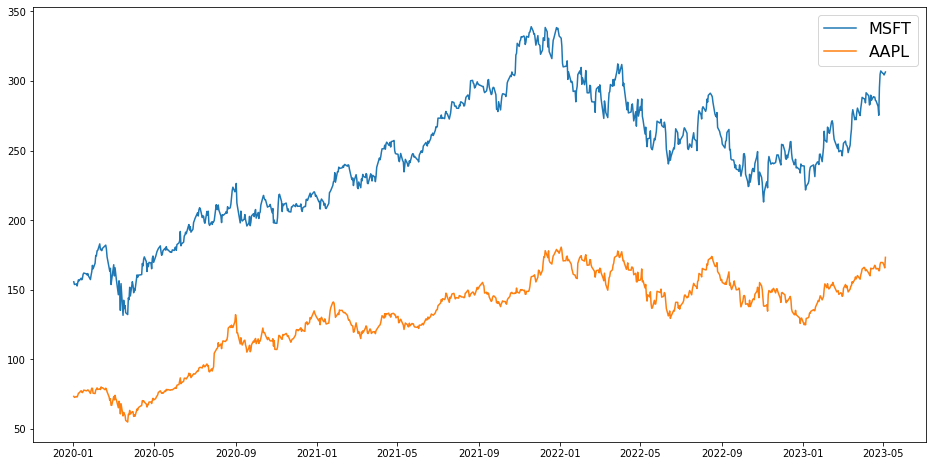

Total returns for each security (assuming they were bought on the start date of 2020-01-01)

MSFT: 96.78%
AAPL: 136.0%

If you had invested $1000 dollars on 2020-01-02 in these assets with the specified portfolio percentages above,
it would be worth $1163.9 today
Max Sharpe Ratio return: 0.25125936896302664, volatility: 0.35078595813592733


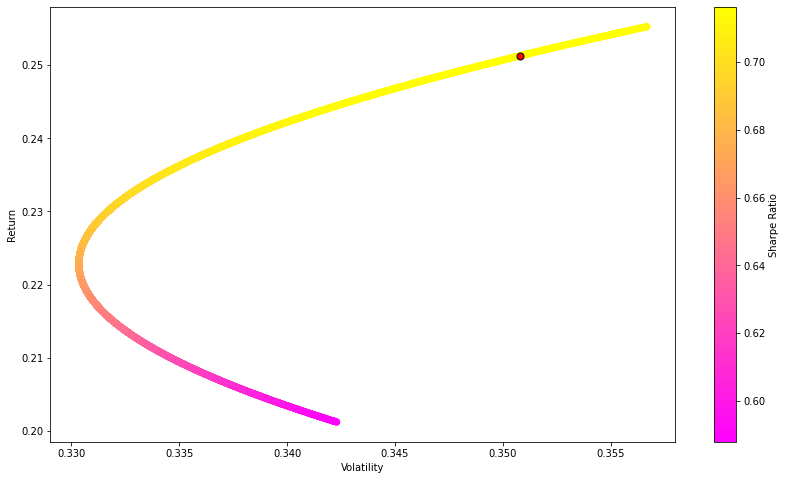

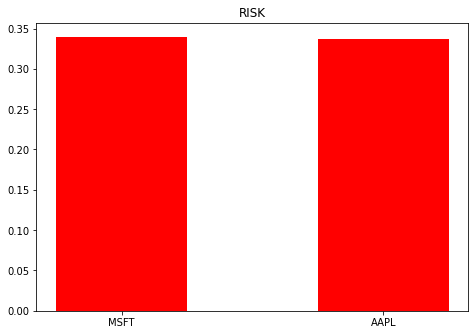

/var/folders/15/bksqy8fx1xj57h5q67zg3r0c0000gn/T/ipykernel_15638/627593898.py:167: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


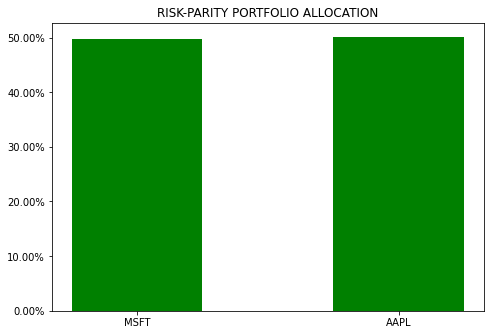

The inputed portfolio consisting of: 

50.0% MSFT
50.0% AAPL

Provides an expected return of 22.82% with volatility of 33.11%.

Markowitz Model (Efficient Frontier)

0.07% MSFT
0.93% AAPL

This optimal blend offers the most efficient option by balancing the expected return and volatility.
The expected return of this portfolio is 25.13% with a volality of 35.08%.
These values were chosen by computing the maximum Sharpe Ratio for all simulations. 
The corresponding ratio value for this blend is 0.716.

Risk-Parity Portfolio

The risk-parity method, which seeks to optimize returns while adhering to market risk parameters, indicates the following blend will be the best and most resilient option:

49.82% MSFT
50.18% AAPL


In [52]:
def main():
    # Initialize the StockSelection and DateSelection classes
    stock_selector = StockSelection()
    date_selector = DateSelection()

    # User selects two stocks
    selected_stocks = stock_selector.select_stocks()
    stock_symbols = [stock['Symbol'] for stock in selected_stocks]

    # User selects start and end dates
    start_date, end_date = date_selector.select_dates()

    assets = stock_symbols
    percentages = [0.5, 0.5]

    # Initialize the FetchData class with the selected stocks and dates
    data_fetcher = FetchData(stock_symbols, start_date, end_date)

    # Fetch and process the stock data
    data_fetcher.fetch_stock_data()

    # Get and print the processed stock data
    stock_data = data_fetcher.get_stock_data()
    for symbol, data in stock_data.items():
        print(f"\nData for {symbol}:")
        print(data)

    # Initialize the GPT_Stock class and get the comparison analysis
    gpt_stock = GPT_Stock(stock_symbols)
    comparison_analysis = gpt_stock.get_comparison_analysis()
    print("\nComparison Analysis:")
    print(comparison_analysis)

    my_portfolio = Portfolio(assets, percentages, start_date)
    my_optimizer = Optimizer(my_portfolio)

    # Display the overlapping stock charts
    my_portfolio.plot_stock_chart()

    # Display the theoretical returns
    my_portfolio.get_theoretical_returns()

    # Run the optimization simulations
    my_optimizer.run_optimization_simulations()

    # Get and display the maximum Sharpe Ratio information
    max_sr_ret, max_sr_vol = my_optimizer.get_max_sharpe_ratio_info()
    print(f"Max Sharpe Ratio return: {max_sr_ret}, volatility: {max_sr_vol}")

    # Display the efficient frontier graph
    my_optimizer.graph_efficient_frontier()

    # Generate and display risk parity
    my_optimizer.generate_risk_parity()
    my_optimizer.graph_asset_risk()
    my_optimizer.graph_risk_parity_allocation()

    # Print the conclusion
    my_optimizer.get_conclusion()

if __name__ == "__main__":
    main()